<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE30338](https://jckantor.github.io/CBE30338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE30338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [First Order System in Pyomo](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.05-First-Order-System-in-Pyomo.ipynb) | [Contents](toc.ipynb) | [Transient Heat Transfer in Various Geometries](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.07-Transient-Heat-Transfer-in-Various-Geometries.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/07.06-Path-Planning-for-a-Simple-Car.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Path Planning for a Simple Car

## Required Installations

If run on Google Colab, it is necessary to install any needed solvers for each Colab session. The following cell tests if the notebook is run on Google Colab, then installs Pyomo and Ipopt if not already installed.

In [0]:
try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt'
except:
    pass

## Kinematic Model


The following equations describe a simple model of a car

\begin{align}
\frac{dx}{dt} & = v \cos(\theta) \\
\frac{dy}{dt} & = v \sin(\theta) \\
\frac{d\theta}{dt} & = \frac{v}{L}\tan(\phi) \\
\end{align}

where $x$ and $y$ denote the position of the center of the rear axle, $\theta$ is the angle of the car axis to the horizontal, $v$ is velocity, and $\phi$ is the angle of the front steering wheels to the car axis. The length $L$ is the distance from the center of the rear axle to the center of the front axle.

The velocity $v$ is controlled by acceleration of the car, the position of the wheels is controlled by the rate limited steering input $v$.

\begin{align}
\frac{dv}{dt} & = a \\
\frac{d\phi}{dt} & = u
\end{align}

The state of the car is determined by the value of the five state variables $x$, $y$, $\theta$, $v$, and $\phi$.

The path planning problem is to find find values of the manipulable variables $a(t)$ and $u(t)$ on a time interval $0 \leq t \leq t_f$ to drive the car from an initial condition $\left[x(0), y(0), \theta(0), v(0), \phi(0)\right]$ to a specified final condition $\left[x(t_f), y(t_f), \theta(t_f), v(t_f), \phi(t_f)\right]$ that minimizes an objective function:

\begin{align}
J  = \min \int_0^{t_f} \left( \phi(t)^2 + \alpha a(t)^2 + \beta u(t)^2\right)\,dt
\end{align}

and which satisfy operational constraints

\begin{align*}
| u | & \leq u_{max}
\end{align*}


## Pyomo Model

In [2]:
from pyomo.environ import *
from pyomo.dae import *

L = 2
tf = 50

# create a model object
m = ConcreteModel()

# define the independent variable
m.t = ContinuousSet(bounds=(0, tf))

# define control inputs
m.a = Var(m.t)
m.u = Var(m.t, domain=Reals, bounds=(-0.1,0.1))

# define the dependent variables
m.x = Var(m.t)
m.y = Var(m.t)
m.theta = Var(m.t)
m.v = Var(m.t)
m.phi = Var(m.t, domain=Reals, bounds=(-0.5,0.5))

m.xdot = DerivativeVar(m.x)
m.ydot = DerivativeVar(m.y)
m.thetadot = DerivativeVar(m.theta)
m.vdot = DerivativeVar(m.v)
m.phidot = DerivativeVar(m.phi)

# define the differential equation as a constraint
m.ode_x = Constraint(m.t, rule=lambda m, t: m.xdot[t] == m.v[t]*cos(m.theta[t]))
m.ode_y = Constraint(m.t, rule=lambda m, t: m.ydot[t] == m.v[t]*sin(m.theta[t]))
m.ode_t = Constraint(m.t, rule=lambda m, t: m.thetadot[t] == m.v[t]*tan(m.phi[t])/L)
m.ode_u = Constraint(m.t, rule=lambda m, t: m.vdot[t] == m.a[t])
m.ode_p = Constraint(m.t, rule=lambda m, t: m.phidot[t] == m.u[t])

# path constraints
m.path_x1 = Constraint(m.t, rule=lambda m, t: m.x[t] >= 0)
m.path_y1 = Constraint(m.t, rule=lambda m, t: m.y[t] >= 0)

# initial conditions
m.ic = ConstraintList()
m.ic.add(m.x[0]==0)
m.ic.add(m.y[0]==0)
m.ic.add(m.theta[0]==0)
m.ic.add(m.v[0]==0)
m.ic.add(m.phi[0]==0)

# final conditions
m.fc = ConstraintList()
m.fc.add(m.x[tf]==0)
m.fc.add(m.y[tf]==20)
m.fc.add(m.theta[tf]==0)
m.fc.add(m.v[tf]==0)
m.fc.add(m.phi[tf]==0)

# define the optimization objective
m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: 0.2*m.phi[t]**2 + m.a[t]**2 + m.u[t]**2)
m.obj = Objective(expr=m.integral)

# transform and solve
TransformationFactory('dae.collocation').apply_to(m, wrt=m.t, nfe=3, ncp=12, method='BACKWARD')
SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 449
  Number of variables: 444
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 1.1693551540374756
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


## Accessing Solution Data

In [0]:
# access the results
t= [t for t in m.t]

a = [m.a[t]() for t in m.t]
u = [m.u[t]() for t in m.t]

x = [m.x[t]() for t in m.t]
y = [m.y[t]() for t in m.t]
theta = [m.theta[t]() for t in m.t]
v = [m.v[t]() for t in m.t]
phi = [m.phi[t]() for t in m.t]

## Visualizing Car Path

(-0.7475794562067691,
 21.812257339073334,
 -1.3839156648530575,
 21.175921130427046)

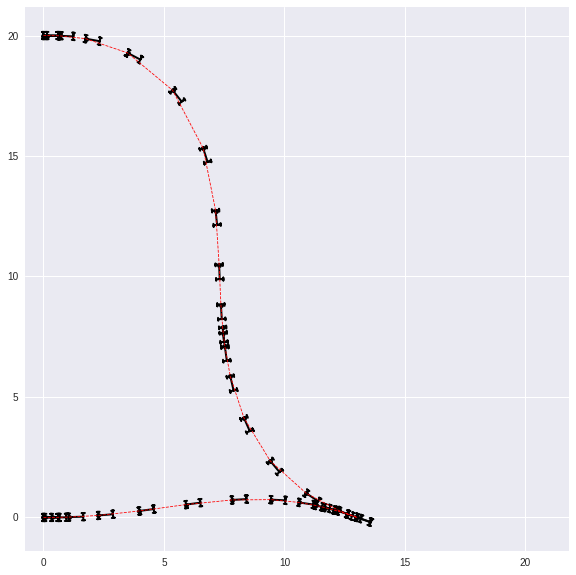

In [4]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

scl=0.3

def draw_car(x=0, y=0, theta=0, phi=0):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    car = np.array([[0.2, 0.5], [-0.2, 0.5], [0, 0.5], [0, -0.5],
                    [0.2, -0.5], [-0.2, -0.5], [0, -0.5], [0, 0], [L, 0], [L, 0.5],
                    [L + 0.2*np.cos(phi), 0.5 + 0.2*np.sin(phi)],
                    [L - 0.2*np.cos(phi), 0.5 - 0.2*np.sin(phi)], [L, 0.5],[L, -0.5],
                    [L + 0.2*np.cos(phi), -0.5 + 0.2*np.sin(phi)],
                    [L - 0.2*np.cos(phi), -0.5 - 0.2*np.sin(phi)]])
    carz= scl*R.dot(car.T)
    plt.plot(x + carz[0], y + carz[1], 'k', lw=2)
    plt.plot(x, y, 'k.', ms=10)
    
plt.figure(figsize=(10,10))
for xs,ys,ts,ps in zip(x,y,theta,phi):   
    draw_car(xs, ys, ts, scl*ps)
plt.plot(x, y, 'r--', lw=0.8)
plt.axis('square')

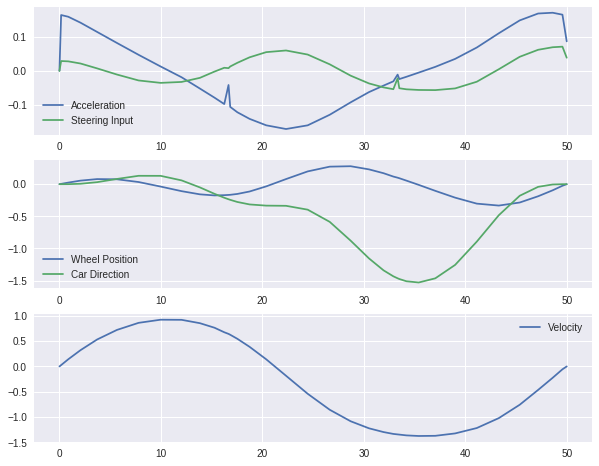

In [5]:
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.plot(t, a, t, u)
plt.legend(['Acceleration','Steering Input'])

plt.subplot(312)
plt.plot(t, phi, t, theta)
plt.legend(['Wheel Position','Car Direction'])

plt.subplot(313)
plt.plot(t, v)
plt.legend(['Velocity'])

<!--NAVIGATION-->
< [First Order System in Pyomo](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.05-First-Order-System-in-Pyomo.ipynb) | [Contents](toc.ipynb) | [Transient Heat Transfer in Various Geometries](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/07.07-Transient-Heat-Transfer-in-Various-Geometries.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/07.06-Path-Planning-for-a-Simple-Car.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>